# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [1]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [2]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [3]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(14, 10, False)
End game! Reward:  -1.0
You lost :(

(8, 1, False)
End game! Reward:  -1.0
You lost :(

(15, 7, False)
End game! Reward:  -1
You lost :(



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [4]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [5]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((16, 10, False), 1, -1)]
[((13, 6, True), 1, 0), ((16, 6, True), 1, 0), ((16, 6, False), 1, -1)]
[((20, 1, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [6]:
from collections import defaultdict
import numpy as np
import sys

# This is every visit MC method for estimating state values.
def every_visit_mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
# Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: 0)
# Use the following returns_sum if you are uncommenting the last section.
#     returns_sum = defaultdict(list)
    N = defaultdict(lambda: 0)
    V = {}
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate an episode.
        episode = generate_episode_from_limit(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discount_multiplyer = np.array([gamma**i for i in range(len(actions)+1)])
        # Calculate and store the return for each visit in the episode.
        for i, state in enumerate(states):
            returns_sum[state] += sum(rewards[i:]*discount_multiplyer[:-(i+1)])
            N[state] += 1.0
            # Calculate the state-value function estimate.
            V[state] =  returns_sum[state]/N[state]
# Some other implementations for estimating the state-value function. To use this instead, uncomment the 
# following section below and comment the above three lines.
#             returns_sum[state].append(sum(rewards[i:]*discount_multiplyer[:-(i+1)]))
#     V = {k:(sum(v)/N[k]) for k, v in returns_sum.items()}
#                       or(uncomment any one of the two )
#     V = {k:np.mean(v) for k, v in returns_sum.items()}
    return V

In [7]:
from collections import defaultdict
import numpy as np
import sys

# This is first visit MC method for estimating state values.
def first_visit_mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: 0)
# Use the following returns_sum if you are uncommenting the last section.
#     returns_sum = defaultdict(list)
    N = defaultdict(lambda: 0)
    V = {}
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # To check for first visit of state in an episode.
        visited = defaultdict(lambda: False)
        # Generate an episode.
        episode = generate_episode_from_limit(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discount_multiplyer = np.array([gamma**i for i in range(len(actions)+1)])
        # Calculate and store the return for each visit in the episode.
        for i, state in enumerate(states):
            if visited[state] == False:
                returns_sum[state] += sum(rewards[i:]*discount_multiplyer[:-(i+1)])
                N[state] += 1.0
                # Calculate the state-value function estimate.
                V[state] =  returns_sum[state]/N[state]
# Some other implementations for estimating the state-value function. To use this instead, uncomment the 
# following section below and comment the above three lines.
#                 returns_sum[state].append(sum(rewards[i:]*discount_multiplyer[:-(i+1)]))
#     V = {k:(sum(v)/N[k]) for k, v in returns_sum.items()}
#                       or(uncomment any one of the two )
#     V = {k:np.mean(v) for k, v in returns_sum.items()}
    return V

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

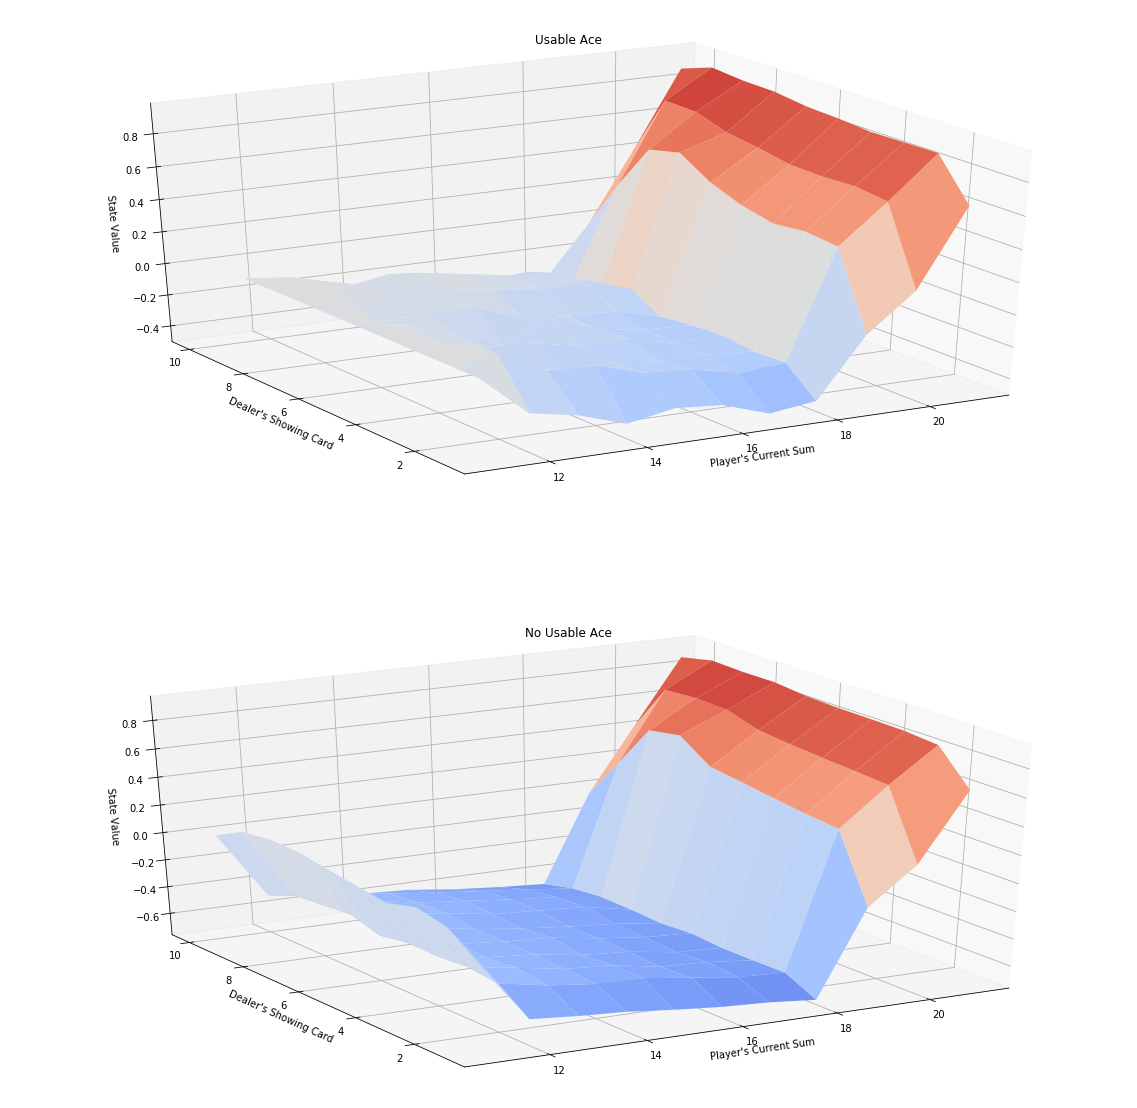

In [10]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = every_visit_mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0]<18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [11]:
# This is every visit MC method for estimating the action value function.
def every_visit_mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Loop over episodes.
    for i_episode in range(1, num_episodes+1):
        # Monitor progress.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate an episode.
        episode = generate_episode(env)
        # Get states, actions and rewards from the episode.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode.
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(i+1)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]]/N[state][actions[i]]
    return Q

In [12]:
# This is first visit MC method for estimating the action value function.
def first_visit_mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        # Monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # To check for first visit of state, action pair in an episode.
        visited = defaultdict(lambda: np.full(shape=env.action_space.n, fill_value = False))
        # Generate an episode.
        episode = generate_episode(env)
        # Obtain states, actions, and rewards.
        states, actions, rewards = zip(*episode)
        # Prepare for discounting.
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # Update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode.
        for i, state in enumerate(states):
            if visited[state][actions[i]] == False: 
                returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
                N[state][actions[i]] += 1.0
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

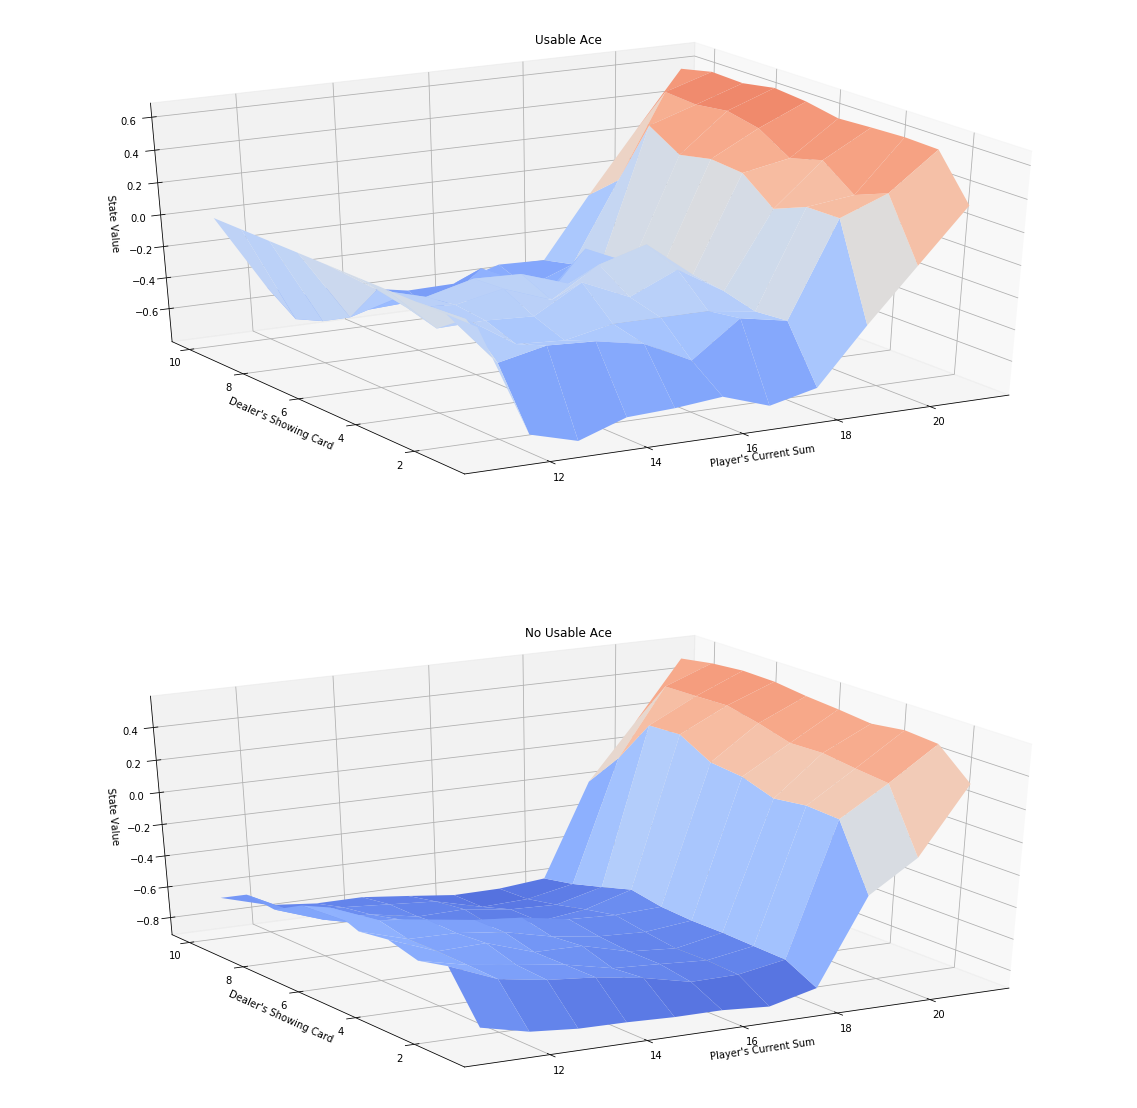

In [13]:
# obtain the action-value function
Q = every_visit_mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)